# Vignette

This vignette extends the [vignette for the R-version of tximport](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html). If you are unfamiliar with `tximport` or curious about the motivation behind it, please check it out.

## Creating your transcript gene mapping

Here, we will show you how to generate a transcript_gene_mapping data frame based on the Gencode or Ensembl reference.

### Build it from Gencode

Directly downloading the annotations and parsing them yourself can be faster than using `pybiomart` when files are not cached.

In [1]:
import gzip
from io import StringIO
import numpy as np
import pandas as pd
import requests

# download the Gencode GeneSymbol metadata file for the species of your samples
reference_url = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.metadata.HGNC.gz"
buffer = StringIO(gzip.decompress(requests.get(reference_url).content).decode("utf-8"))
transcript_gene_mapping = pd.read_table(buffer, sep="\t", header=None)

transcript_gene_mapping.columns = ["transcript_id", "gene_id", "hgnc_code"]
transcript_gene_mapping.head(5)

,transcript_id,gene_id,hgnc_code
0,ENST00000511072.5,PRDM16,HGNC:14000
1,ENST00000607632.1,PRDM16,HGNC:14000
2,ENST00000378391.6,PRDM16,HGNC:14000
3,ENST00000514189.5,PRDM16,HGNC:14000
4,ENST00000270722.10,PRDM16,HGNC:14000


### Build it from Ensembl

This example requires `pybiomart`.

In [2]:
%pip install pybiomart -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pybiomart import Dataset

In [4]:
dataset = Dataset(name="hsapiens_gene_ensembl", host="http://www.ensembl.org")
transcript_gene_mapping_human = dataset.query(attributes=["ensembl_transcript_id", "external_gene_name"])
transcript_gene_mapping_human.columns = ["transcript_id", "gene_id"]
transcript_gene_mapping_human.head(5)

,transcript_id,gene_id
0,ENST00000387314,MT-TF
1,ENST00000389680,MT-RNR1
2,ENST00000387342,MT-TV
3,ENST00000387347,MT-RNR2
4,ENST00000386347,MT-TL1


In [5]:
dataset = Dataset(name="mmusculus_gene_ensembl", host="http://www.ensembl.org")
transcript_gene_mapping_mouse = dataset.query(attributes=["ensembl_transcript_id", "external_gene_name"])
transcript_gene_mapping_mouse.columns = ["transcript_id", "gene_id"]
transcript_gene_mapping_mouse.head(5)

,transcript_id,gene_id
0,ENSMUST00000082387,mt-Tf
1,ENSMUST00000082388,mt-Rnr1
2,ENSMUST00000082389,mt-Tv
3,ENSMUST00000082390,mt-Rnr2
4,ENSMUST00000082391,mt-Tl1


## Importing transcript quantification files

You can easily import quantification files from tools like `salmon` with `pytximport`.

In [6]:
from pytximport import tximport

In [7]:
txi = tximport(
    ["../../test/data/salmon/multiple/Sample_1.sf", "../../test/data/salmon/multiple/Sample_2.sf"],
    "salmon",
    transcript_gene_mapping_mouse,
    output_type="xarray",  # or "anndata"
)
txi

Reading quantification files: 2it [00:00, 286.74it/s]


<xarray.Dataset> Size: 87kB
Dimensions:    (gene_id: 495, file: 2, file_path: 2)
Coordinates:
  * gene_id    (gene_id) <U32 63kB 'Gm11581' 'Casp2' ... 'Ankrd28' 'Prkag1'
  * file_path  (file_path) <U43 344B '../../test/data/salmon/multiple/Sample_...
Dimensions without coordinates: file
Data variables:
    abundance  (gene_id, file) float64 8kB 0.08291 0.0 0.09854 ... 0.4618 0.0
    counts     (gene_id, file) float64 8kB 1.001 0.0 1.042 ... 2.0 6.184 0.0
    length     (gene_id, file) float64 8kB 509.1 509.1 445.8 ... 564.6 564.6

## Exporting transcript-level count estimates

You can also export the transformed transcript counts directly for transcript-level analysis.

In [8]:
txi = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    counts_from_abundance="scaled_tpm",  # provide a transcript_gene_mapping and use "dtu_scaled_tpm"
    return_transcript_data=True,
)
txi

Reading quantification files: 1it [00:00, 317.13it/s]


AnnData object with n_obs × n_vars = 1 × 14
    obsm: 'length', 'abundance'

Note that the example above works without a transcript to gene mapping. If you want to use the transcript names instead of the transcript ides, you can optionally use the `replace_transcript_ids_with_names` function together with a transcript id to transcript name mapping.

In [9]:
from pytximport.utils import replace_transcript_ids_with_names

In [10]:
dataset = Dataset(name="hsapiens_gene_ensembl", host="http://www.ensembl.org")
transcript_name_mapping_human = dataset.query(attributes=["ensembl_transcript_id", "external_transcript_name"])
transcript_name_mapping_human.columns = ["transcript_id", "transcript_name"]
transcript_name_mapping_human.head(5)

,transcript_id,transcript_name
0,ENST00000387314,MT-TF-201
1,ENST00000389680,MT-RNR1-201
2,ENST00000387342,MT-TV-201
3,ENST00000387347,MT-RNR2-201
4,ENST00000386347,MT-TL1-201


In [11]:
txi = replace_transcript_ids_with_names(txi, transcript_name_mapping_human)
pd.DataFrame(txi.X.T, index=txi.var.index, columns=txi.obs.index).sort_values(
    by=txi.obs.index[0],
    ascending=False,
).head(5)

,../../test/data/salmon/quant.sf
HOXC8-201,4486.940412
UGT3A2-201,1307.314695
HOXC9-201,886.909534
HOXC4-202,749.069369
HOXC12-201,544.817685


The same data summarized to genes:

In [12]:
txi = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    transcript_gene_mapping_human,
    counts_from_abundance="scaled_tpm",
    output_type="xarray",
    return_transcript_data=False,
)
pd.DataFrame(txi["counts"], index=txi.coords["gene_id"], columns=txi.coords["file_path"]).sort_values(
    by=txi.coords["file_path"].data[0],
    ascending=False,
).head(5)

Reading quantification files: 1it [00:00, 372.40it/s]


,../../test/data/salmon/quant.sf
HOXC8,4486.940412
UGT3A2,1506.597257
HOXC4,1152.964133
HOXC9,886.909534
HOXC12,544.817685


Note that the top transcript corresponds to the top expressed gene in this case.

## Exporting AnnData files

`pytximport` integrates well with other packages from the `scverse` through its `AnnData` export option.

In [13]:
txi_ad = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    transcript_gene_mapping_human,
    output_type="anndata",
    # the output can optionally be saved to a file by uncommenting the following lines
    # output_format="h5ad",
    # save_path="txi_ad.h5ad",
)
txi_ad

Reading quantification files: 1it [00:00, 425.69it/s]


AnnData object with n_obs × n_vars = 1 × 10
    obsm: 'length', 'abundance'

## Use from the command line

You can run `pytximport` from the command line, too. Available options can be viewed via the `pytximport --help` command.

In [14]:
!pytximport -i ../../test/data/salmon/quant.sf -t "salmon" -m ../../test/data/gencode.v46.metadata.HGNC.tsv --output_type "anndata" --output_format "h5ad" -o ../../test/data/salmon/quant.h5ad

2024-07-05 22:47:21,863: Starting the import.
Reading quantification files: 1it [00:00, 315.98it/s]
2024-07-05 22:47:22,023: Converting transcript-level expression to gene-level expression.
2024-07-05 22:47:22,202: Matching gene_ids.
2024-07-05 22:47:22,336: Creating gene abundance.
2024-07-05 22:47:22,486: Creating gene counts.
2024-07-05 22:47:22,486: Creating lengths.
2024-07-05 22:47:22,490: Replacing missing lengths.
2024-07-05 22:47:22,492: Creating gene expression dataset.
2024-07-05 22:47:22,495: Saving the gene-level expression to: ../../test/data/salmon/quant.h5ad.
2024-07-05 22:47:22,499: Finished the import in 0.64 seconds.


## Inferential replicates

`pytximport` can handle bootstraping replicates provided by `salmon` and `kallisto`. When `inferential_replicate_transformer` is set, the provided function is used to recalculate the counts and abundances for each sample based on the bootstraps.

In [15]:
result = tximport(
    [
        "../../test/data/fabry_disease/SRR16504309_wt/",
        "../../test/data/fabry_disease/SRR16504310_wt/",
        "../../test/data/fabry_disease/SRR16504311_ko/",
        "../../test/data/fabry_disease/SRR16504312_ko/",
    ],
    "salmon",
    transcript_gene_mapping,
    inferential_replicates=True,
    inferential_replicate_variance=True,  # whether to calculate the variance of the inferential replicates
    inferential_replicate_transformer=lambda x: np.median(x, axis=1),
    counts_from_abundance="length_scaled_tpm",
)
result

Reading quantification files: 4it [00:01,  2.90it/s]


AnnData object with n_obs × n_vars = 4 × 40682
    uns: 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

## Downstream analysis with PyDESeq2

The output from `pytximport` can easily be used for downstream analysis with `PyDESeq2`. For more information on `PyDESeq2`, please consult its [documentation](https://pydeseq2.readthedocs.io/en/latest/).

In [16]:
%pip install pydeseq2 decoupler adjustText omnipath tqdm seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [17]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc

Load the .csv file generated by `pytximport` via the `save_path` argument or create it directly from the output of `pytximport`. In this case, we are working with the salmon quantification files from a public bulk RNA sequencing dataset: [Podocyte injury in Fabry nephropathy](https://www.ebi.ac.uk/ena/browser/view/PRJNA773084)

Round count estimates (required by PyDESeq2) and add the corresponding metadata.

In [18]:
result.X = result.X.round().astype(int)
result.obs["condition"] = [
    "Control",
    "Control",
    "Disease",
    "Disease",
]
result

AnnData object with n_obs × n_vars = 4 × 40682
    obs: 'condition'
    uns: 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

Filter genes with low counts out.

In [19]:
result = result[:, result.X.max(axis=0) > 10].copy()
result

AnnData object with n_obs × n_vars = 4 × 14640
    obs: 'condition'
    uns: 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

Now perform your `PyDESeq2` analysis.

In [20]:
dds = DeseqDataSet(
    adata=result,
    design_factors="condition",
    refit_cooks=True,
    inference=DefaultInference(n_cpus=8),
)

In [21]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.79 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

/Users/au734063/Documents/code/pytximport-publish/pytximport/.venv/lib/python3.10/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.03 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [22]:
stat_result = DeseqStats(dds, contrast=("condition", "Disease", "Control"))

In [23]:
stat_result.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Disease vs Control
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
WASH7P       11.942124        2.494967  1.491251  1.673070  9.431359e-02   
WASH9P       32.046507       -1.077308  0.870677 -1.237323  2.159673e-01   
MTND2P28    918.539561       -0.422244  0.194643 -2.169324  3.005810e-02   
MTCO1P12     37.702474       -1.271206  0.739829 -1.718243  8.575234e-02   
MTATP6P1   1814.030883       -0.498075  0.147393 -3.379235  7.268783e-04   
...                ...             ...       ...       ...           ...   
MT-ND6     5604.707541       -0.849599  0.123355 -6.887424  5.681152e-12   
MT-TE       144.531129       -1.042600  0.388501 -2.683647  7.282404e-03   
MT-CYB    12671.785609       -0.387906  0.110456 -3.511870  4.449662e-04   
MT-TT        32.508066       -1.442121  0.799880 -1.802922  7.140048e-02   
MT-TP        44.729892       -1.193370  0.681097 -1.752130  7.975142e-02   

                  pa

... done in 0.51 seconds.



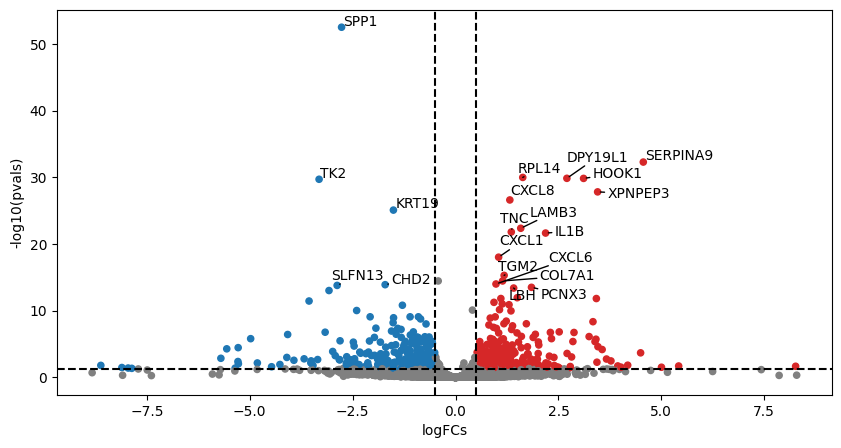

In [24]:
dc.plot_volcano_df(stat_result.results_df, x="log2FoldChange", y="padj", top=20, figsize=(10, 5))

/Users/au734063/Documents/code/pytximport-publish/pytximport/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
118kB [00:00, 819MB/s]


Running ulm on mat with 1 samples and 14640 targets for 660 sources.


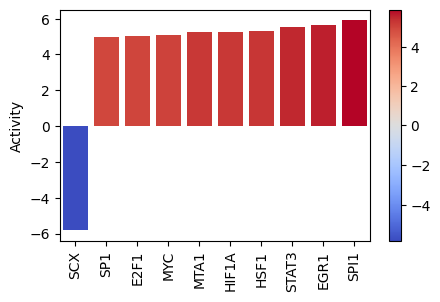

In [25]:
collectri = dc.get_collectri(organism="human", split_complexes=False)
mat = stat_result.results_df[["stat"]].T.rename(index={"stat": "disease.vs.control"})
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
dc.plot_barplot(acts=tf_acts, contrast="disease.vs.control", top=10, vertical=False, figsize=(5, 3))

We can also evaluate known pathways.

In [26]:
progeny = dc.get_progeny(top=500)
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, min_n=5)

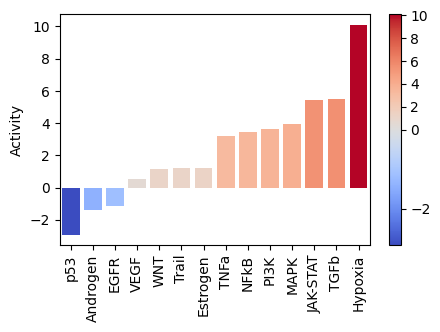

In [27]:
dc.plot_barplot(acts=pathway_acts, contrast="disease.vs.control", top=40, vertical=False, figsize=(5, 3))

Please refer to the `PyDESeq2` and the `decoupler` documentation for additional analyses.